In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics, rich
from dataclasses import dataclass, field
from IPython.display import display, display_markdown, Markdown
from datetime import datetime

def print_markdown(string):
    display(Markdown(string))

In [54]:

@dataclass
class HandshakeSizes:
    edhoc_csv_file: str
    dtls_csv_file: str
    dtls_cert_csv_file: str
    edhoc_df: pd.DataFrame = None
    dtls_df: pd.DataFrame = None
    dtls_cert_df: pd.DataFrame = None

    def __post_init__(self):
        self.edhoc_df = pd.read_csv(self.edhoc_csv_file)
        self.dtls_df = pd.read_csv(self.dtls_csv_file)
        self.dtls_cert_df = pd.read_csv(self.dtls_cert_csv_file)

        # annotate steps and calculate total
        self.edhoc_df.insert(0, 'step', ['Message 1', 'Message 2', 'Message 3', 'Final Ack'])
        self.edhoc_df.set_index('step', inplace=True)
        self.edhoc_df.loc['_total'] = self.edhoc_df.sum(numeric_only=True)

        dtls_steps = ['Client Hello', 'Server Hello', 'Client Hello (cookie)', 'Server Hello', 'Encrypted Extensions', 'Certificate', 'Certificate Verify', 'Server Finished', 'Client Finished', 'Ack']
        self.dtls_df.insert(0, 'step', dtls_steps)
        self.dtls_df.set_index('step', inplace=True)
        self.dtls_df.loc['_total'] = self.dtls_df.sum(numeric_only=True)

        dtls_cert_steps = ['Client Hello', 'Server Hello', 'Client Hello (cookie)', 'Server Hello', 'Encrypted Extensions', 'Certificate', 'Certificate Verify', '', '', 'Server Finished', 'Client Finished', 'Ack']
        self.dtls_cert_df.insert(0, 'step', dtls_cert_steps)
        self.dtls_cert_df.set_index('step', inplace=True)
        self.dtls_cert_df.loc['_total'] = self.dtls_cert_df.sum(numeric_only=True)

    def plot(self):
        total_row_edhoc = self.edhoc_df.loc['_total'].drop(['_sum', '# of fragments'])
        total_row_dtls = self.dtls_df.loc['_total'].drop(['_sum', '# of fragments'])
        total_row_dtls_cert = self.dtls_cert_df.loc['_total'].drop(['_sum', '# of fragments'])

        color_dict = {
            'IEEE 802.15.4': 'tab:blue',
            '6LoWPAN': 'firebrick',
            'CoAP': 'tab:green', 
            'Content': 'tab:orange'
        }

        # Columns to plot
        columns_df1 = total_row_edhoc.index
        columns_df2 = total_row_dtls.index
        columns_df3 = total_row_dtls_cert.index

        # Create a list of values for each DataFrame
        values_df1 = total_row_edhoc.values
        values_df2 = total_row_dtls.values
        values_df3 = total_row_dtls_cert.values

        fig, ax = plt.subplots()

        bottom_value = 0
        for i, col_name in enumerate(columns_df1):
            ax.bar('EDHOC', values_df1[i], bottom=bottom_value, label=col_name, color=color_dict[col_name])
            bottom_value += values_df1[i]

        bottom_value = 0
        for i, col_name in enumerate(columns_df2):
            ax.bar('DTLS RPK', values_df2[i], bottom=bottom_value, label=col_name, color=color_dict[col_name])
            bottom_value += values_df2[i]

        bottom_value = 0
        for i, col_name in enumerate(columns_df3):
            ax.bar('DTLS Cert', values_df3[i], bottom=bottom_value, label=col_name, color=color_dict[col_name])
            bottom_value += values_df3[i]

        # Only display one legend entry per unique label
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(dict.fromkeys(labels).keys())
        unique_handles = [handles[labels.index(lb)] for lb in unique_labels]

        ax.set_ylabel('Total (bytes))')
        ax.set_title('Accumulated bytes over the air for EDHOC and DTLS 1.3')
        ax.legend(unique_handles, unique_labels)

        plt.show()

    def results(self, plot=True):
        print_markdown("# Bytes over the air: ")
        display(self.edhoc_df.style.set_caption("EDHOC:"))
        display(self.dtls_df.style.set_caption("DTLS RPK:"))
        display(self.dtls_cert_df.style.set_caption("DTLS Cert:"))
        if plot:
            self.plot()

# hs_sizes = HandshakeSizes("./results/edhoc_pcap.csv", "./results/dtls_rpk_pcap.csv", "./results/dtls_cert_pcap.csv")
# hs_sizes.results()

In [81]:
@dataclass
class Handshake:
    _df: pd.DataFrame
    start: float
    end: float

    @property
    def df(self):
        return self._df.iloc[self.start:self.end]

    def with_offset(self, offset):
        return Handshake(self._df, self.start-offset, self.end+offset)

    def with_lines_offset_se(self, offset_s, offset_e):
        return Handshake(self._df, self.start-offset_s, self.end+offset_e)

    @property
    def start_ms(self):
        return self._df['timestamp'].iloc[self.start]

    @property
    def end_ms(self):
        return self._df['timestamp'].iloc[self.end]

    @property
    def duration_ms(self): # in milliseconds
        return round((self.end_ms - self.start_ms) * 1000, 2)

    @property
    def energy_mj(self): # in millijoules
        time_step = 0.000250 # seconds
        joules = (self.df['power'] * time_step).sum()
        return round(joules * 1000, 2)

    @property
    def power_avg(self):
        return self.df['power'].mean()

    def __str__(self) -> str:
        return f"""Duration (ms): {self.duration_ms}
Energy (mJ): {self.energy_mj}"""

    def __repr__(self) -> str:
        dic = {
            "duration": self.duration_ms,
            "energy": self.energy_mj,
        }
        return str(dic)

class DataLoader:
    csv_files_otii = {
        "current": "Main current - Arc.csv",
        "power": "Main power - Arc.csv",
        "gpio": "GPI 1 - Arc.csv",
    }

    # @lru_cache
    def find_handshakes(df):
        # convert NaN to an arbitrary integer
        df['gpio'] = df['gpio'].fillna(-9).astype(int)

        gpio_values = df['gpio'].values
        in_handshake = False
        hs_start, hs_end = 0, 0
        handshakes = []
        for index, value in enumerate(gpio_values):
            if not in_handshake and value == 1:
                in_handshake = True
                hs_start = index
            elif in_handshake and value == 0:
                in_handshake = False
                hs_end = index
                hs = Handshake(df, hs_start, hs_end)
                handshakes.append(hs)

            if in_handshake:
                gpio_values[index] = 1

        # convert temporary value to 0
        gpio_values[gpio_values == -9] = 0
        # Update the 'gpio' column in the DataFrame
        df['gpio'] = gpio_values
        return df, handshakes

    def run(results_dir):
        dfs = []

        for source, csv_file in DataLoader.csv_files_otii.items():
            filename = f"{results_dir}/{csv_file}"
            df = pd.read_csv(filename)
            df = df.rename(columns={'Timestamp': 'timestamp'})
            df = df.rename(columns={'Value': source})
            # print(df.head())
            dfs.append(df)

        merged_df = dfs[0]
        for df in dfs[1:]:
            merged_df = merged_df.merge(df, on="timestamp", how="outer")

        merged_df, handshakes = DataLoader.find_handshakes(merged_df)

        return merged_df, handshakes

def mean_stdev(arr, ndigits=2):
    return round(statistics.mean(arr), ndigits), round(statistics.stdev(arr), ndigits)

@dataclass
class HandshakeSet:
    label: str
    csv_folder: str
    df: pd.DataFrame = field(default_factory=pd.DataFrame)
    handshakes: list = field(default_factory=list)

    def __post_init__(self):
        self.df, self.handshakes = DataLoader.run(self.csv_folder)

    def __getitem__(self, index):
        return self.handshakes[index]

    def duration_mean_stdev(self):
        return mean_stdev([hs.duration_ms for hs in self.handshakes])

    def energy_mean_stdev(self):
        return mean_stdev([hs.energy_mj for hs in self.handshakes])

    def power_mean(self):
        return round(statistics.mean([hs.power_avg for hs in self.handshakes]), 2)

    def __repr__(self) -> str:
        return str(self.summary())

    def summary(self):
        return {
            'label': self.label,
            'handshakes': len(self.handshakes),
            'duration': self.duration_mean_stdev(),
            'energy': self.energy_mean_stdev(),
            'power': self.power_mean(),
        }

@dataclass
class HandshakeMemory():
    csv_file: str
    df: pd.DataFrame = None

    def __post_init__(self):
        self.df = pd.read_csv(self.csv_file).set_index('protocol')
        self.df = (self.df / 1000) #.astype(int) # convert to kB
        self.df['Flash'] = self.df[['text', 'data']].sum(axis=1)
        self.df['RAM'] = self.df[['data', 'bss', 'stack']].sum(axis=1)

    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        colors = {
            'text': 'tab:blue',
            'data': 'firebrick',
            'bss': 'tab:green', 
            'stack': 'tab:orange'
        }
        xtick_labels = ['EDHOC', 'DTLS RPK', 'DTLS CERT']

        self.df[['data', 'bss', 'stack']].plot(kind='bar', stacked=True, ax=ax1, zorder=5, color=[colors['data'], colors['bss'], colors['stack']])
        ax1.set_xticklabels(xtick_labels, rotation=0)  # rotation=0 makes labels horizontal
        ax1.set_title('RAM Usage')
        ax1.set_xlabel('Protocol')
        ax1.set_ylabel('RAM Usage (kB)')

        self.df[['text', 'data']].plot(kind='bar', stacked=True, ax=ax2, zorder=5, color=[colors['text'], colors['data']])
        ax2.set_xticklabels(xtick_labels, rotation=0)
        ax2.set_title('Flash Usage')
        ax2.set_xlabel('Protocol')
        ax2.set_ylabel('Flash Usage (kB)')

        [ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, zorder=1) for ax in [ax1, ax2]]

        plt.subplots_adjust(wspace=0.3)
        # plt.tight_layout()
        plt.show()

    def percentage_of(self, p1='edhoc', p2='dtls_rpk'):
        return {
            'RAM': round(self.df.loc[p1, 'RAM'] / self.df.loc[p2, 'RAM'] * 100, 2),
            'Flash': round(self.df.loc[p1, 'Flash'] / self.df.loc[p2, 'Flash'] * 100, 2),
        }

    def summary(self):
        return {
            'text': self.df['text'].to_dict(),
            'data': self.df['data'].to_dict(),
            'bss': self.df['bss'].to_dict(),
            'stack': self.df['stack'].to_dict(),
        }

@dataclass
class HandshakeLog:
    filename: str
    target_duration_mean_ms: float
    log_text: str = None

    def __post_init__(self):
        with open(self.filename) as f:
            self.log_text = f.read()

    def get_scaled_timestamps_and_messages(self):
        # Parsing log text
        timestamps = []
        messages = []
        for line in self.log_text.strip().split("\n"):
            timestamp_str, message = line.split(" # ")
            timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")
            timestamps.append(timestamp)
            messages.append(message)

        # Convert timestamps to seconds, starting from 0
        start_time = timestamps[0]
        timestamps_in_seconds = [(t - start_time).total_seconds() for t in timestamps]
        # return timestamps_in_seconds, messages

        # Re-scale timestamps to X ms
        original_duration = timestamps_in_seconds[-1] - timestamps_in_seconds[0]
        target_duration = self.target_duration_mean_ms / 1000
        scaling_factor = target_duration / original_duration
        rescaled_timestamps_in_seconds = [t * scaling_factor for t in timestamps_in_seconds]

        return zip(rescaled_timestamps_in_seconds, messages)


@dataclass
class Experiment:
    label: str
    csv_folder_edhoc: str
    csv_folder_dtls: str
    csv_folder_dtls_cert: str
    memory: HandshakeMemory
    sizes: HandshakeSizes
    edhoc_log_file: str = None
    dtls_log_file: str = None
    dtls_cert_log_file: str = None
    edhoc_hs: HandshakeSet = None
    dtls_hs: HandshakeSet = None
    edhoc_hs_log: HandshakeLog = None
    dtls_hs_log: HandshakeLog = None

    def __post_init__(self):
        self.edhoc_hs = HandshakeSet("edhoc", self.csv_folder_edhoc)
        self.dtls_hs = HandshakeSet("dtls", self.csv_folder_dtls)
        self.dtls_cert_hs = HandshakeSet("dtls", self.csv_folder_dtls_cert)
        if self.edhoc_log_file:
            self.edhoc_hs_log = HandshakeLog(self.edhoc_log_file, self.edhoc_hs.duration_mean_stdev()[0])
        if self.dtls_log_file:
            self.dtls_hs_log = HandshakeLog(self.dtls_log_file, self.dtls_hs.duration_mean_stdev()[0])

    def plot_durations(self):
        protocols_names = ['EDHOC', 'DTLS RPK', 'DTLS Cert']
        df = self.summary_handshakes_df()

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        bar_positions = [0, 0.5]

        df['duration_avg'].plot(kind='bar', ax=ax1, yerr=df['duration_std'], capsize=10, zorder=5)
        ax1.set_xticklabels(protocols_names, rotation=0)
        ax1.set_ylabel('Handshake Duration (ms)')
        ax1.set_title('Handshake Duration')

        df['energy_avg'].plot(kind='bar', ax=ax2, yerr=df['energy_std'], capsize=10, zorder=5)
        ax2.set_xticklabels(protocols_names, rotation=0)
        ax2.set_ylabel('Handshake Energy (mJ)')
        ax2.set_title('Handshake Energy Consumption')

        [ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, zorder=1) for ax in [ax1, ax2]]

        plt.subplots_adjust(wspace=0.2)
        # plt.tight_layout()
        plt.show()

    def plot_handshake_instance(self, hs, protocol, index, os=200, oe=200, plot_logs=False):
        offset_hs = hs.with_lines_offset_se(os, oe)

        # compute offset difference to milliseconds
        offset_start_ms = hs.start_ms - offset_hs.start_ms
        offset_end_ms = offset_start_ms + (hs.duration_ms / 1000)

        offset_hs._df = offset_hs._df.copy()
        # make timestamp being from 0, and also compensate the start (left side) offset
        # offset_hs._df['timestamp'] = offset_hs._df['timestamp'] - offset_hs.start_ms
        offset_hs._df['timestamp'] = offset_hs._df['timestamp'] - offset_hs.start_ms - offset_start_ms

        # convert amps to milliamps
        offset_hs._df['current'] = offset_hs._df['current'] * 1000

        plt.figure(figsize=(18, 3))
        plt.plot(offset_hs.df['timestamp'], offset_hs.df['current'], label='Current (mA)')

        if plot_logs:
            if "EDHOC" in protocol:
                # using hs.duration_ms because we want the actual value, not the mean
                log = HandshakeLog(self.edhoc_log_file, hs.duration_ms)
            elif "DTLS RPK" in protocol:
                log = HandshakeLog(self.dtls_log_file, hs.duration_ms)
            elif "DTLS Cert" in protocol:
                log = HandshakeLog(self.dtls_cert_log_file, hs.duration_ms)
            y_position_for_text = plt.ylim()[1]
            for x, message in log.get_scaled_timestamps_and_messages():
                if "begin handshake" in message or "end handshake ok" in message:
                    continue
                color = 'grey'
                linewidth = 1
                plt.axvline(x=x, color=color, linestyle='-', linewidth=linewidth)
                plt.text(x, y_position_for_text, message, rotation=60, ha='left', va='bottom', fontsize=8)
        else:
            # add text above
            duration_position_x = (offset_hs.start_ms + offset_hs.end_ms) / 2
            y_position = plt.ylim()[1] * 1.03
            plt.text(duration_position_x, y_position, f"{protocol} -- handshake #{index}\n{hs}", ha='center')

        # draw vertical red lines at start and stop
        plt.axvline(x=0, color='red')
        plt.axvline(x=offset_end_ms-offset_start_ms, color='red', linewidth=2)

        # print(offset_hs.df['timestamp'].min(), offset_hs.df['timestamp'].max())
        # TODO: this should be automated from min and max, but it is not working
        # plt.xlim(0, 0.33)
        plt.xlim(0-offset_start_ms, 0.42-offset_start_ms)

        plt.xlabel('Timestamp (s)')
        plt.ylabel('Current (mA)')
        plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, zorder=1)

        plt.legend()
        plt.show()

    # def plot_handshake_instance_comparison(self, edhoc_hs, dtls_hs, index, plot_logs=False):
    #     offset_for_larger_left = offset_for_smaller_left = 100
    #     offset_for_larger_right = 200
    #     offset_for_smaller_right = ((dtls_hs.end - dtls_hs.start) - (edhoc_hs.end - edhoc_hs.start)) + offset_for_larger_right

    #     self.plot_handshake_instance(edhoc_hs, "EDHOC", index, offset_for_smaller_left, offset_for_smaller_right, plot_logs)
    #     self.plot_handshake_instance(dtls_hs, "DTLS RPK", index, offset_for_larger_left, offset_for_larger_right, plot_logs)

    def plot_handshake_instance_comparison(self, edhoc_hs, dtls_hs, dtls_cert_hs, index, plot_logs=False):
        offset_left = 100
        offset_for_larger_right = 200
        offset_for_edhoc_right = ((dtls_cert_hs.end - dtls_cert_hs.start) - (edhoc_hs.end - edhoc_hs.start)) + offset_for_larger_right
        offset_for_dtls_right = ((dtls_cert_hs.end - dtls_cert_hs.start) - (dtls_hs.end - dtls_hs.start)) + offset_for_larger_right

        self.plot_handshake_instance(edhoc_hs, "EDHOC", index, offset_left, offset_for_edhoc_right, plot_logs)
        self.plot_handshake_instance(dtls_hs, "DTLS RPK", index, offset_left, offset_for_dtls_right, plot_logs)
        self.plot_handshake_instance(dtls_cert_hs, "DTLS Cert", index, offset_left, offset_for_larger_right, plot_logs)

    def summary_handshakes_df(self):
        edhoc_sum = self.edhoc_hs.summary()
        dtls_sum = self.dtls_hs.summary()
        dtls_cert_sum = self.dtls_cert_hs.summary()
        df = pd.DataFrame({
            'protocol': ['edhoc', 'dtls_rpk', 'dtls_cert'],
            'handshakes': [edhoc_sum['handshakes'], dtls_sum['handshakes'], dtls_cert_sum['handshakes']],
            'duration_avg': [edhoc_sum['duration'][0], dtls_sum['duration'][0], dtls_cert_sum['duration'][0]],
            'duration_std': [edhoc_sum['duration'][1], dtls_sum['duration'][1], dtls_cert_sum['duration'][1]],
            'energy_avg': [edhoc_sum['energy'][0], dtls_sum['energy'][0], dtls_cert_sum['energy'][0]],
            'energy_std': [edhoc_sum['energy'][1], dtls_sum['energy'][1], dtls_cert_sum['energy'][1]],
            'power_avg': [edhoc_sum['power'], dtls_sum['power'], dtls_cert_sum['power']],
        })
        df.set_index('protocol', inplace=True)
        return df

    def handshakes_percentage_of(self, p1='edhoc', p2='dtls_rpk'):
        df = self.summary_handshakes_df()
        return {
            'Duration': round(df.loc[p1, 'duration_avg'] / df.loc[p2, 'duration_avg'] * 100, 2),
            'Energy': round(df.loc[p1, 'energy_avg'] / df.loc[p2, 'energy_avg'] * 100, 2),
        }

    def summary(self):
        return {
            'label': self.label,
            'edhoc_hs': self.edhoc_hs.summary(),
            'dtls_hs': self.dtls_hs.summary(),
            'memory': self.memory.summary(),
        }

    def results(self, cmp_idx=0):
        print_markdown("# Summary: ")
        res = self.handshakes_percentage_of()
        res.update(self.memory.percentage_of())
        rich.print(f"EDHOC percentage of DTLS RPK: {res}")
        res = self.handshakes_percentage_of(p2='dtls_cert')
        res.update(self.memory.percentage_of(p2='dtls_cert'))
        rich.print(f"EDHOC percentage of DTLS Cert: {res}")

        print_markdown("# Handshake duration and energy (ms, mJ, mW): ")
        display(self.summary_handshakes_df())
        rich.print(f"EDHOC percentage of DTLS RPK: {self.handshakes_percentage_of()}")
        rich.print(f"EDHOC percentage of DTLS Cert: {self.handshakes_percentage_of(p2='dtls_cert')}")
        print("Chart: ")
        self.plot_durations()

        print_markdown("# Memory usage (kB): ")
        display(self.memory.df)
        rich.print(f"EDHOC percentage of DTLS RPK: {self.memory.percentage_of()}")
        rich.print(f"EDHOC percentage of DTLS Cert: {self.memory.percentage_of(p2='dtls_cert')}")
        print("Chart: ")
        self.memory.plot()

        self.sizes.results(plot=True)

        print_markdown("# A peek at one particular handshake (red lines mean start/stop of the handshake procedure): ")
        self.plot_handshake_instance_comparison(self.edhoc_hs[cmp_idx], self.dtls_hs[cmp_idx], self.dtls_cert_hs[cmp_idx], cmp_idx, plot_logs=False)

        print_markdown("# A peek at one particular handshake, with logs*: ")
        print_markdown("*note that there are significant skew due to collecting logs with serial port ON.")
        self.plot_handshake_instance_comparison(self.edhoc_hs[cmp_idx], self.dtls_hs[cmp_idx], self.dtls_cert_hs[cmp_idx], cmp_idx, plot_logs=True)


# Summary: 

EDHOC percentage of DTLS RPK: {'Duration': 71.13, 'Energy': 69.67, 'RAM': 29.6, 'Flash': 54.42}

EDHOC percentage of DTLS Cert: {'Duration': 53.67, 'Energy': 53.32, 'RAM': 29.37, 'Flash': 54.19}

# Handshake duration and energy (ms, mJ, mW): 

,handshakes,duration_avg,duration_std,energy_avg,energy_std,power_avg
protocol,,,,,,
edhoc,20,183.10,2.47,6.34,0.06,0.03
dtls_rpk,20,257.40,2.30,9.10,0.06,0.04
dtls_cert,20,341.15,6.05,11.89,0.16,0.03


EDHOC percentage of DTLS RPK: {'Duration': 71.13, 'Energy': 69.67}

EDHOC percentage of DTLS Cert: {'Duration': 53.67, 'Energy': 53.32}

Chart: 


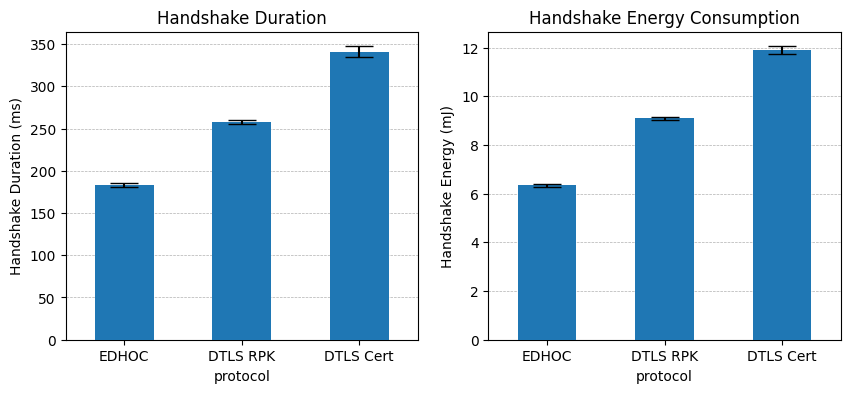

# Memory usage (kB): 

,text,data,bss,stack,Flash,RAM
protocol,,,,,,
edhoc,142.008,0.836,46.356,9.888,142.844,57.080
dtls_rpk,261.800,0.676,185.056,7.100,262.476,192.832
dtls_cert,261.416,2.196,185.056,7.124,263.612,194.376


EDHOC percentage of DTLS RPK: {'RAM': 29.6, 'Flash': 54.42}

EDHOC percentage of DTLS Cert: {'RAM': 29.37, 'Flash': 54.19}

Chart: 


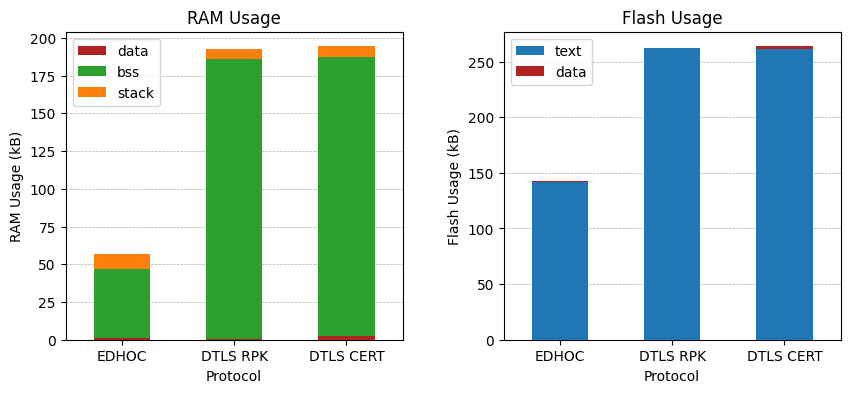

# Bytes over the air: 

,# of fragments,IEEE 802.15.4,6LoWPAN,CoAP,Content,_sum
step,,,,,,
Message 1,1,21,9,26,38,94
Message 2,1,21,9,8,45,83
Message 3,1,21,9,26,20,76
Final Ack,1,21,9,6,0,36
_total,4,84,36,66,103,289


,# of fragments,IEEE 802.15.4,6LoWPAN,Content,_sum
step,,,,,
Client Hello,3,63,23,206,292
Server Hello,2,42,18,144,204
Client Hello (cookie),3,63,23,279,365
Server Hello,2,42,18,144,204
Encrypted Extensions,1,21,5,45,71
Certificate,2,42,18,134,194
Certificate Verify,2,42,18,108,168
Server Finished,1,21,5,70,96
Client Finished,1,21,5,70,96


,# of fragments,IEEE 802.15.4,6LoWPAN,Content,_sum
step,,,,,
Client Hello,3,63,23,194,280
Server Hello,2,42,18,144,204
Client Hello (cookie),3,63,23,267,353
Server Hello,2,42,18,144,204
Encrypted Extensions,1,21,5,40,66
Certificate,10,210,58,895,1163
Certificate Verify,2,42,18,109,169
,1,21,5,70,96
,1,21,5,70,96


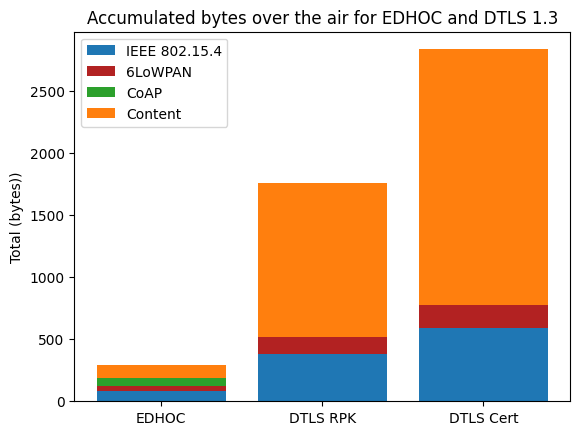

# A peek at one particular handshake (red lines mean start/stop of the handshake procedure): 

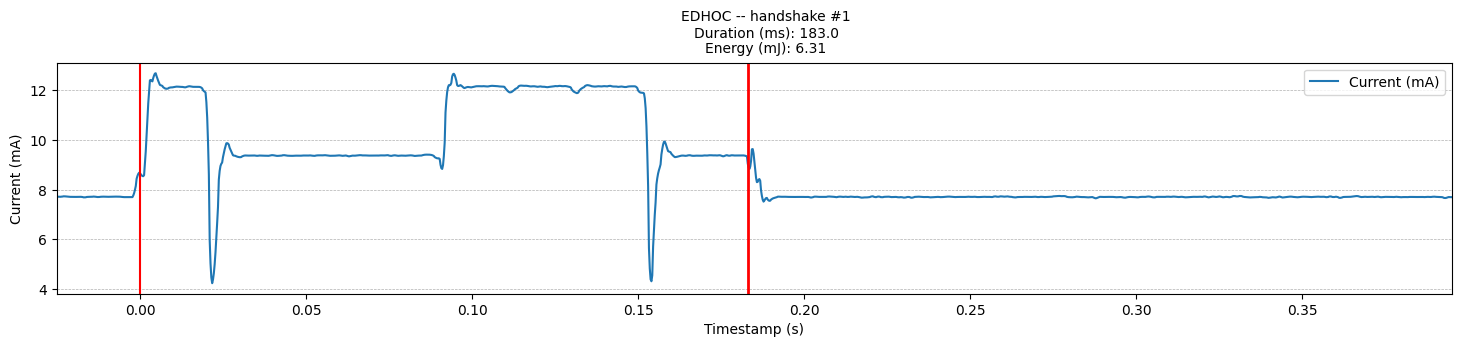

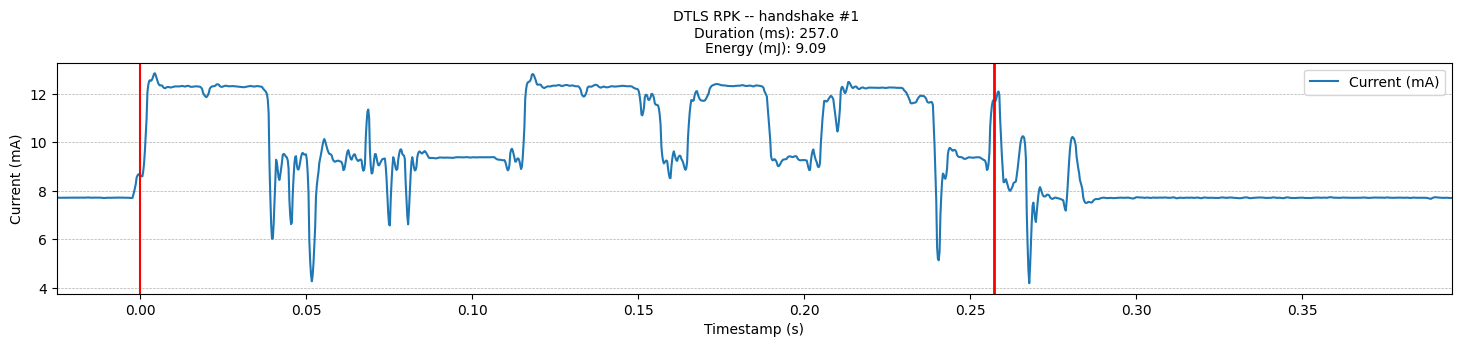

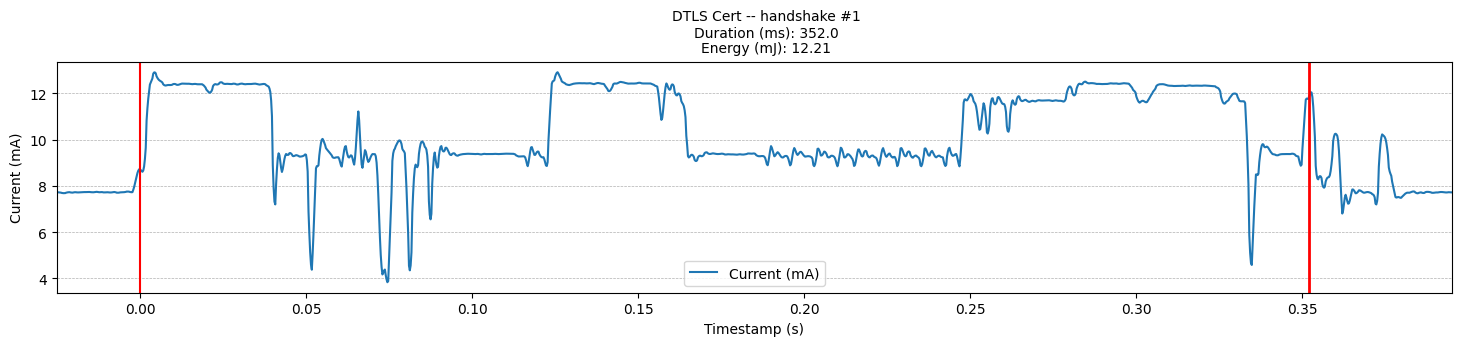

# A peek at one particular handshake, with logs*: 

*note that there are significant skew due to collecting logs with serial port ON.

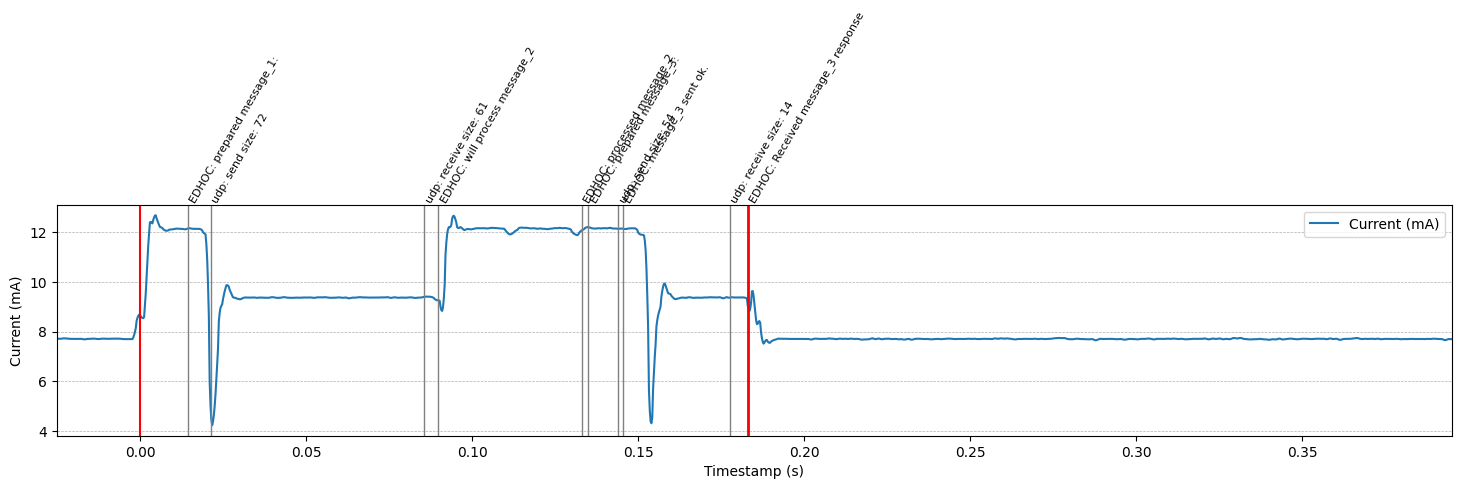

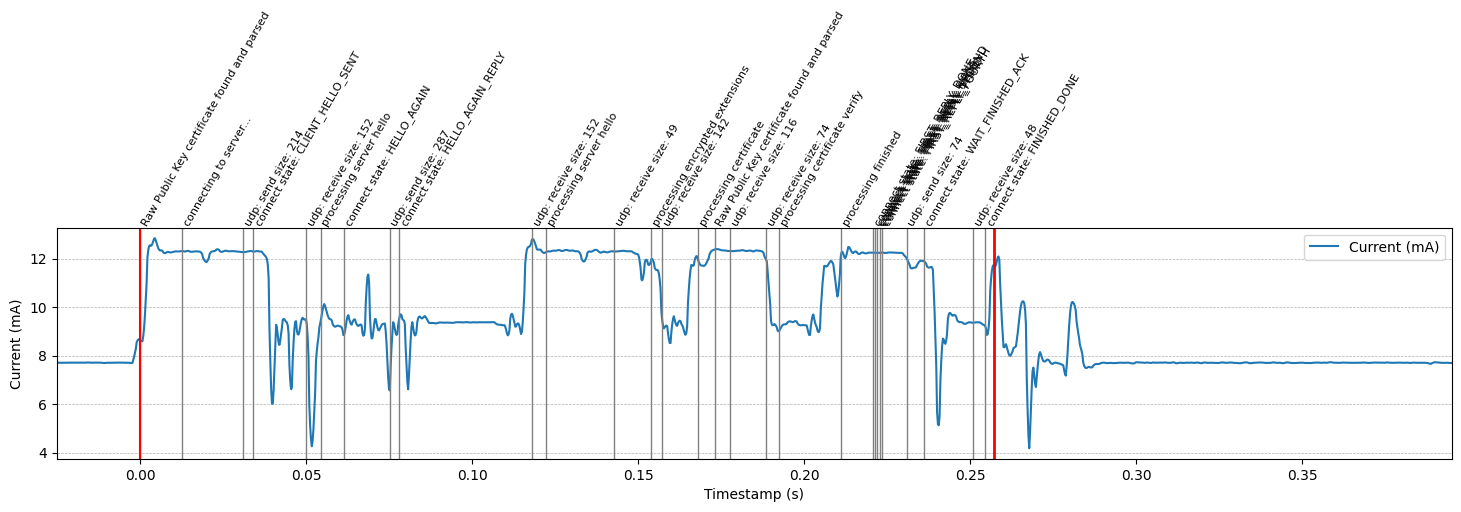

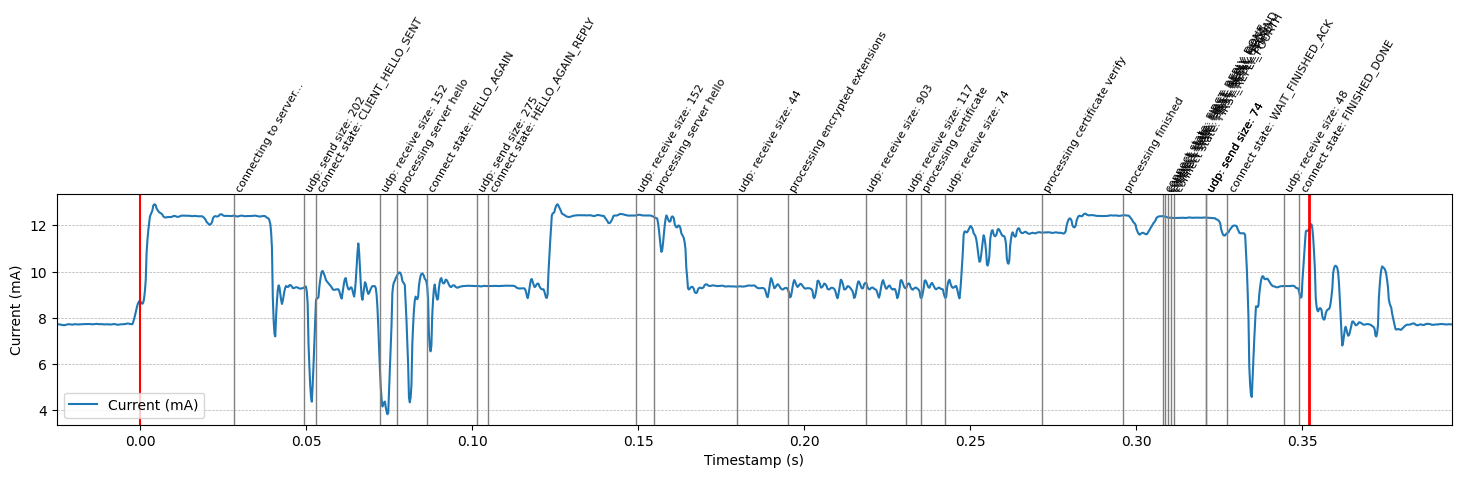

In [82]:
experiment = Experiment(
    "edhoc_vs_dtls-09aug",
    "./results/edhoc-21aug-16h22-csv",
    "./results/dtls-21aug-16h26-csv",
    "./results/dtls-30aug-14h52-csv",
    # HandshakeMemory("./results/memory-2023-08-21_15:55:20.csv"),
    HandshakeMemory("./results/memory-2023-08-30_14:28:09.csv"),
    HandshakeSizes("./results/edhoc_pcap.csv", "./results/dtls_rpk_pcap.csv", "./results/dtls_cert_pcap.csv"),
    "./results/edhoc_rs.log",
    "./results/dtls-rpk-wolfssl.log",
    "./results/dtls-cert-wolfssl.log",
)

experiment.results(1)